In [1]:
import numpy as np
import pandas as pd

import torch
import time
import copy
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, cross_val_score

import brevitas.nn as nn

from config import *
from classic_models import *
from data_preprocessing import *
from feature_extraction import *
from helpers import *

from torch.utils.data import DataLoader
from tslearn.preprocessing import TimeSeriesScalerMinMax

import warnings
warnings.filterwarnings("ignore")

Dance move: 1, Name: gun_john
Dance move: 2, Name: hair_john
Dance move: 3, Name: sidepump_john


In [2]:
from sklearn import preprocessing
df = pd.read_csv('out_2.csv')
# temp = df['tag']
# del df['tag']

# x = df.values #returns a numpy array
# col = df.columns
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled, columns=col)

# df['tag'] = temp
df['tag'] = df['tag'].apply(lambda x: x-1)
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_test = df[~msk]
df.head()

,mean_accel1,mean_accel2,mean_accel3,mean_gyro1,mean_gyro2,mean_gyro3,max_accel1,max_accel2,max_accel3,max_gyro1,...,var_coeff_gyro1,var_coeff_gyro2,var_coeff_gyro3,kurtosis_accel1,kurtosis_accel2,kurtosis_accel3,kurtosis_gyro1,kurtosis_gyro2,kurtosis_gyro3,tag
0,0.321713,0.587304,0.19189,0.224644,0.132784,3.0,0.08,0.412742,-1.510622,0.425019,...,0.512475,0.670569,0.403010,0.465719,0.091719,1.0,0.46,0.178974,-1.346002,0.0
1,0.290898,0.515375,0.18489,0.219044,0.117643,3.0,0.12,0.404411,-1.121981,0.454103,...,0.506555,0.670569,0.403010,0.467391,0.089168,1.0,0.42,0.176028,-1.119453,0.0
2,0.261652,0.499783,0.16476,0.215231,0.098955,3.0,0.12,0.378192,0.209323,0.482450,...,0.510602,0.670569,0.403010,0.469900,0.086363,2.0,0.34,0.169140,-1.079949,0.0
3,0.236798,0.463143,0.16476,0.212382,0.072249,3.0,0.12,0.305106,3.957013,0.498670,...,0.507860,0.670569,0.341137,0.469900,0.089625,2.0,0.38,0.176476,-0.980839,0.0
4,0.221092,0.355008,0.16476,0.212382,0.035674,3.0,0.12,0.161354,4.649814,0.501705,...,0.472475,0.670569,0.177258,0.461538,0.115898,2.0,0.34,0.245300,0.466311,0.0


In [3]:
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        if isinstance(df, pd.DataFrame):
            df_np = df.to_numpy()

        self.X = df_np[:,:-1]
        self.y = df_np[:,-1]

    def __getitem__(self, idx):
        # get item by index
        return self.X[idx], self.y[idx]

    def __len__(self):
        # returns length of data
        return len(self.X)

In [4]:
dataset = FeatureDataset(df_train)
D_in = df.shape[1]-1
D_out = len(dances)

In [5]:
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv1d, MaxPool1d, Module, Softmax, BatchNorm1d, Dropout, Flatten

class CNN(torch.nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super(CNN, self).__init__()
        self.relu = torch.nn.ReLU()
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5)
        self.conv2 = torch.nn.Conv1d(in_channels=64,out_channels=64, kernel_size=5)
        self.conv3 = torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5)
        self.conv4 = torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5)
        self.lstm1 = torch.nn.LSTM(
            input_size=14,
            hidden_size=32,
            num_layers=2,
            batch_first=False,
        )
        self.fc2 = torch.nn.Linear(42, d_out)
        
        self.dropout = torch.nn.Dropout(p=0.15) 
        
    def forward(self,x):
        x = x.float().unsqueeze(dim=1)
        x = self.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.relu(self.conv3(x))
#         x = self.relu(self.conv4(x))
#         x,_ = self.lstm1(x)
        x = x[:, -1]
        x = self.fc2(x)
        return x
    
    def load(self, model_path):
        self.load_state_dict(torch.load(model_path))
        self.eval()

    def predict(self, X):
        outputs = self(X.float())
        _, predicted = torch.max(outputs, 1)
        return predicted

In [6]:
def train_val_model(model, criterion, optimizer, num_epochs=25,
        scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store losses and accuracies accross epochs
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    tscv = TimeSeriesSplit(n_splits=20)

    X_train, X_test, y_train, y_test = train_test_split(
        dataset.X.reshape(dataset.X.shape[0],-1), dataset.y, test_size=0.33, random_state=42
    )

    for i in range(num_epochs):
        if log_interval is not None and i % log_interval == 0:
            print('Epoch {}/{}'.format(i, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
        for fold, (train_index, test_index) in enumerate(tscv.split(X_train, y_train)):
            ### Dividing data into folds
            x_train_fold = X_train[train_index]
            x_test_fold = X_train[test_index]
            y_train_fold = y_train[train_index]
            y_test_fold = y_train[test_index]

            print('Train Index Length:', len(x_train_fold), end='\t\t')
            print('Test Index Length:', len(x_test_fold), end='\n\n')

            train = torch.utils.data.TensorDataset(torch.tensor(x_train_fold), torch.tensor(y_train_fold))
            test = torch.utils.data.TensorDataset(torch.tensor(x_test_fold), torch.tensor(y_test_fold))
            train_loader = torch.utils.data.DataLoader(train, batch_size = 20, shuffle = False)
            test_loader = torch.utils.data.DataLoader(test, batch_size = 20, shuffle = False)

        
            running_loss = 0.0
            running_corrects = 0
            model.train()
            for batch_index, (x_batch, y_batch) in enumerate(train_loader):
                optimizer.zero_grad()
                y_pred = model(x_batch)
                _, preds = torch.max(y_pred, 1)
                
                single_loss = criterion(y_pred, y_batch.long().view(-1))
                single_loss.backward()
                optimizer.step()
                
                running_loss += single_loss.item() * x_batch.size(0)
                running_corrects += torch.sum(preds == y_batch.data)
            print('Fold No. {}/{}\tEpoch {}/{}\t'.format(fold + 1 , tscv.get_n_splits(), i + 1, num_epochs), end='')
            print(f'loss: {single_loss.item():10.8f}')
            
            nsamples = len(train_index)
            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if log_interval is not None and i % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                    phase, epoch_loss, 100 * epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.2f}%'.format(100 * best_acc))
    print()

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies

In [7]:
model = CNN(D_in, 50, D_out)
# optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Explore the model
for parameter in model.parameters():
    print(parameter.shape)

print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))

torch.Size([64, 1, 5])
torch.Size([64])
torch.Size([64, 64, 5])
torch.Size([64])
torch.Size([64, 64, 5])
torch.Size([64])
torch.Size([64, 64, 5])
torch.Size([64])
torch.Size([128, 14])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([3, 42])
torch.Size([3])
Total number of parameters = 76737


In [8]:
model, losses, accuracies = train_val_model(model, criterion, optimizer, num_epochs=10, log_interval=1)

Epoch 0/9
----------
Train Index Length: 38		Test Index Length: 31

Fold No. 1/20	Epoch 1/10	loss: 1.09437346
val Loss: 1.0937 Acc: 26.32%
Train Index Length: 69		Test Index Length: 31

Fold No. 2/20	Epoch 1/10	loss: 1.10512888
val Loss: 1.0978 Acc: 24.64%
Train Index Length: 100		Test Index Length: 31

Fold No. 3/20	Epoch 1/10	loss: 1.09104013
val Loss: 1.0969 Acc: 29.00%
Train Index Length: 131		Test Index Length: 31

Fold No. 4/20	Epoch 1/10	loss: 1.09161603
val Loss: 1.0969 Acc: 31.30%
Train Index Length: 162		Test Index Length: 31

Fold No. 5/20	Epoch 1/10	loss: 1.13918281
val Loss: 1.0962 Acc: 33.95%
Train Index Length: 193		Test Index Length: 31

Fold No. 6/20	Epoch 1/10	loss: 1.08847451
val Loss: 1.0956 Acc: 34.20%
Train Index Length: 224		Test Index Length: 31

Fold No. 7/20	Epoch 1/10	loss: 1.09320641
val Loss: 1.0952 Acc: 34.38%
Train Index Length: 255		Test Index Length: 31

Fold No. 8/20	Epoch 1/10	loss: 1.09436035
val Loss: 1.0953 Acc: 34.12%
Train Index Length: 286		Test

Fold No. 9/20	Epoch 4/10	loss: 0.57780463
val Loss: 0.4374 Acc: 81.12%
Train Index Length: 317		Test Index Length: 31

Fold No. 10/20	Epoch 4/10	loss: 0.40285006
val Loss: 0.4214 Acc: 82.65%
Train Index Length: 348		Test Index Length: 31

Fold No. 11/20	Epoch 4/10	loss: 0.40507784
val Loss: 0.4013 Acc: 84.20%
Train Index Length: 379		Test Index Length: 31

Fold No. 12/20	Epoch 4/10	loss: 0.27944720
val Loss: 0.4021 Acc: 84.43%
Train Index Length: 410		Test Index Length: 31

Fold No. 13/20	Epoch 4/10	loss: 0.50589651
val Loss: 0.3906 Acc: 84.15%
Train Index Length: 441		Test Index Length: 31

Fold No. 14/20	Epoch 4/10	loss: 0.09926165
val Loss: 0.4014 Acc: 85.03%
Train Index Length: 472		Test Index Length: 31

Fold No. 15/20	Epoch 4/10	loss: 0.35241929
val Loss: 0.4098 Acc: 84.96%
Train Index Length: 503		Test Index Length: 31

Fold No. 16/20	Epoch 4/10	loss: 0.20335603
val Loss: 0.3744 Acc: 87.08%
Train Index Length: 534		Test Index Length: 31

Fold No. 17/20	Epoch 4/10	loss: 0.2966381

Fold No. 18/20	Epoch 7/10	loss: 0.30095583
val Loss: 0.2581 Acc: 89.91%
Train Index Length: 596		Test Index Length: 31

Fold No. 19/20	Epoch 7/10	loss: 0.12158020
val Loss: 0.2715 Acc: 90.44%
Train Index Length: 627		Test Index Length: 31

Fold No. 20/20	Epoch 7/10	loss: 0.54981530
val Loss: 0.2623 Acc: 89.47%
Epoch 7/9
----------
Train Index Length: 38		Test Index Length: 31

Fold No. 1/20	Epoch 8/10	loss: 0.27191326
val Loss: 0.2732 Acc: 89.47%
Train Index Length: 69		Test Index Length: 31

Fold No. 2/20	Epoch 8/10	loss: 0.35285807
val Loss: 0.2260 Acc: 91.30%
Train Index Length: 100		Test Index Length: 31

Fold No. 3/20	Epoch 8/10	loss: 0.23414993
val Loss: 0.2432 Acc: 90.00%
Train Index Length: 131		Test Index Length: 31

Fold No. 4/20	Epoch 8/10	loss: 0.35568959
val Loss: 0.2591 Acc: 86.26%
Train Index Length: 162		Test Index Length: 31

Fold No. 5/20	Epoch 8/10	loss: 0.04587612
val Loss: 0.2446 Acc: 91.36%
Train Index Length: 193		Test Index Length: 31

Fold No. 6/20	Epoch 8/10	l

In [12]:
torch.save(model.state_dict(), 'CNN_Model')

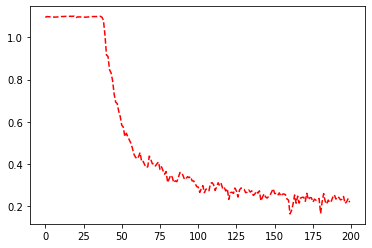

In [13]:
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [14]:
cnn_model = CNN(D_in, 50, D_out)
cnn_model.load('CNN_Model')
cnn_model.eval()

for to_predict in range(D_out):
    df_target = df_test[df_test['tag'] == to_predict]

    df_random = df_test

    df_filtered = torch.from_numpy(np.array(pd.merge(df_target, df_random))[:,:-1])
    output = cnn_model.predict(df_filtered)
    # print(output)
    proba_dict = {}

    for x in output:
        x = int(x)
        if x not in proba_dict:
            proba_dict[x] = 1
        else:
            proba_dict[x] += 1
    for k in proba_dict.keys():
        proba_dict[k] /= len(output)

    print(dict(sorted(proba_dict.items(), key=lambda item: -item[1])))

{0: 0.8055555555555556, 2: 0.1388888888888889, 1: 0.05555555555555555}
{1: 0.9560439560439561, 0: 0.04395604395604396}
{2: 0.9042553191489362, 0: 0.0851063829787234, 1: 0.010638297872340425}
